# Model training
Pytorch tutorial: [optimization_tutorial](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html)

## Prerequisite Code

In [2]:
!pip install torchsummary

In [37]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms
import pandas as pd
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import numpy as np
import os
from torchsummary import summary

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

num_workers = os.cpu_count()
print(f"num_workers = {num_workers} cores")

Using cpu device
num_workers = 16 cores


In [6]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

batch_size=64
# train_dataloader = DataLoader(training_data, batch_size=batch_size,num_workers=num_workers)
# test_dataloader = DataLoader(test_data, batch_size=batch_size,num_workers=num_workers)

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [7]:
im,label=training_data.__getitem__(0)
print(im.shape)
print(label)

torch.Size([1, 28, 28])
9


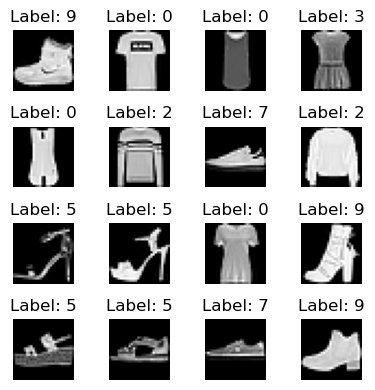

In [8]:
# prompt: show 16 image from training_data using 4*4 grid

import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 4, figsize=(4, 4))
for i in range(16):
    row = i // 4
    col = i % 4
    im, label = training_data.__getitem__(i)
    axes[row, col].imshow(im.squeeze(), cmap='gray')
    axes[row, col].set_title(f"Label: {label}")
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [9]:
class CNNNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 16, kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3,padding=1),
            nn.ReLU(),
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(8*7*7, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        out = self.fc(x)
        return out

In [10]:
model = CNNNetwork()
model.to(device)
print(model)

CNNNetwork(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Sequential(
    (0): Linear(in_features=392, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)


## Hyperparameters

## Optimization Loop

In [65]:
# Training loop (1 epoch)
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        X, y = X.to(device), y.to(device).long()
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


In [66]:
# Testing loop
def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device).long()
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [13]:
#Loss function
loss_fn = nn.CrossEntropyLoss()

#Optimizer
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#Epochs
epochs = 5

In [14]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.304819  [   64/60000]
loss: 0.837137  [ 6464/60000]
loss: 0.458885  [12864/60000]
loss: 0.621450  [19264/60000]
loss: 0.505866  [25664/60000]
loss: 0.504003  [32064/60000]
loss: 0.422104  [38464/60000]
loss: 0.541665  [44864/60000]
loss: 0.519534  [51264/60000]
loss: 0.485345  [57664/60000]
Test Error: 
 Accuracy: 84.9%, Avg loss: 0.410163 

Epoch 2
-------------------------------
loss: 0.289739  [   64/60000]
loss: 0.377113  [ 6464/60000]
loss: 0.223405  [12864/60000]
loss: 0.469015  [19264/60000]
loss: 0.407861  [25664/60000]
loss: 0.402262  [32064/60000]
loss: 0.308721  [38464/60000]
loss: 0.453234  [44864/60000]
loss: 0.402151  [51264/60000]
loss: 0.379749  [57664/60000]
Test Error: 
 Accuracy: 86.9%, Avg loss: 0.354119 

Epoch 3
-------------------------------
loss: 0.213217  [   64/60000]
loss: 0.267404  [ 6464/60000]
loss: 0.203721  [12864/60000]
loss: 0.374062  [19264/60000]
loss: 0.323418  [25664/60000]
loss: 0.375824  [32064/600

# Workshop13 image classification
data: [https://drive.google.com/file/d/1yCH8zIGo9KjdscRfrvpR1R7mel4uq1GH/view?usp=drive_link](https://drive.google.com/file/d/1yCH8zIGo9KjdscRfrvpR1R7mel4uq1GH/view?usp=drive_link)

สร้างโมเดล และทำการฝึกโมเดลเพื่อทำนาย (วินิจฉัย) จากภาพเอกซเรย์ ฟร้อมวัดประสิทธิภาพ

(พิเศษ) เพิ่มการป้องกัน overfitting ด้วยเทคนิค early stopping โดยพิจารณาจาก validation loss หาก validation loss เพิ่มขึ้นเกินจำนวน epoch ที่กำหนดให้หยุดฝึกโมเดล

In [ ]:
# !gdown 1yCH8zIGo9KjdscRfrvpR1R7mel4uq1GH

Downloading...
From (original): https://drive.google.com/uc?id=1yCH8zIGo9KjdscRfrvpR1R7mel4uq1GH
From (redirected): https://drive.google.com/uc?id=1yCH8zIGo9KjdscRfrvpR1R7mel4uq1GH&confirm=t&uuid=1417206b-f644-458a-9441-879f69fe6367
To: /content/Small_Data_CoV2.zip
100% 123M/123M [00:00<00:00, 177MB/s]


In [ ]:
# !unzip Small_Data_CoV2.zip

In [18]:
import pandas as pd
import os
#Create empty lists
df_dic = {}
filename = []
label = []
root_path = r'D:\KKU_World\Learn\second_year\2_1\aiWorkshop\for_final_exam\clone_for_retry_workshop\data\Small_Data_CoV2'
#read all file from subfolders
for foldername in ['Small_Data_CoV2_train', 'Small_Data_CoV2_test', 'Small_Data_CoV2_val']:
    for dirname, _, filenames in os.walk(os.path.join(root_path, foldername)):
        for file in filenames:
            f = os.path.join(dirname, file)
            if '.png' in f:
                filename.append(f)
                # print(dirname.split('\\')[10])
                label.append(dirname.split('\\')[-2])
    #Create a dataframe
    df_dic[foldername.split('_')[-1]] = pd.DataFrame({'filename':filename, 'label':label})
df_dic['train']

,filename,label
0,D:\KKU_World\Learn\second_year\2_1\aiWorkshop\...,Covid
1,D:\KKU_World\Learn\second_year\2_1\aiWorkshop\...,Covid
2,D:\KKU_World\Learn\second_year\2_1\aiWorkshop\...,Covid
3,D:\KKU_World\Learn\second_year\2_1\aiWorkshop\...,Covid
4,D:\KKU_World\Learn\second_year\2_1\aiWorkshop\...,Covid
...,...,...
592,D:\KKU_World\Learn\second_year\2_1\aiWorkshop\...,Others
593,D:\KKU_World\Learn\second_year\2_1\aiWorkshop\...,Others
594,D:\KKU_World\Learn\second_year\2_1\aiWorkshop\...,Others
595,D:\KKU_World\Learn\second_year\2_1\aiWorkshop\...,Others


In [ ]:
le = LabelEncoder()
df_dic['train']['label'] = le.fit_transform(df_dic['train']['label'])
df_dic['train']

In [23]:
from sklearn.model_selection import train_test_split
X = df_dic['train']['filename']
y = df_dic['train']['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
class CustomImageDataset(Dataset):
    def __init__(self, im_filename, y, transform=None):
        self.im_filename = im_filename
        self.y = y
        self.transform = transform

    def __len__(self):
        return self.im_filename.shape[0]

    def __getitem__(self, idx):
        img_path = self.im_filename.iloc[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.y.iloc[idx]

        if self.transform:
            image = self.transform(image)
        image = np.array(image)
        return image, label

In [42]:
conv = nn.Sequential(
    nn.Conv2d(3, 32,kernel_size=3,padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(32, 64, kernel_size=3,padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(64, 64, kernel_size=3,padding=1),
    nn.ReLU(),
)

conv.to(device)
summary(conv, input_size=(3, 224, 224), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
              ReLU-2         [-1, 32, 224, 224]               0
         MaxPool2d-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 64, 112, 112]          18,496
              ReLU-5         [-1, 64, 112, 112]               0
         MaxPool2d-6           [-1, 64, 56, 56]               0
            Conv2d-7           [-1, 64, 56, 56]          36,928
              ReLU-8           [-1, 64, 56, 56]               0
Total params: 56,320
Trainable params: 56,320
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 44.41
Params size (MB): 0.21
Estimated Total Size (MB): 45.20
----------------------------------------------------------------


In [43]:
class CNNNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 64, kernel_size=3,padding=1),
            nn.ReLU(),
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(64*56*56, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 3),
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        out = self.fc(x)
        return out

In [56]:
import torchvision.transforms as transforms

# Define the transformations for the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to the input size of VGG16
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip images horizontally
    # transforms.RandomVerticalFlip(p=0.5),  # Randomly flip images vertically
    transforms.RandomRotation(degrees=5),  # Randomly rotate images by up to 10 degrees
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])

In [57]:
train_dataset = CustomImageDataset(X_train, y_train, transform)
test_dataset = CustomImageDataset(X_test, y_test, test_transform)
im, label = train_dataset.__getitem__(0)
print(label, im.shape)

0 (3, 224, 224)


In [58]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [67]:
model = CNNNetwork()
model.to(device)

#Loss function
loss_fn = nn.CrossEntropyLoss()

#Optimizer
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#Epochs
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 1.080468  [   32/  477]
loss: 1.037369  [  672/  477]
Test Error: 
 Accuracy: 58.3%, Avg loss: 0.977789 

Epoch 2
-------------------------------
loss: 1.058388  [   32/  477]
loss: 0.973087  [  672/  477]
Test Error: 
 Accuracy: 58.3%, Avg loss: 0.926765 

Epoch 3
-------------------------------
loss: 1.102734  [   32/  477]
loss: 0.879206  [  672/  477]
Test Error: 
 Accuracy: 62.5%, Avg loss: 0.856776 

Epoch 4
-------------------------------
loss: 0.686486  [   32/  477]
loss: 0.709508  [  672/  477]
Test Error: 
 Accuracy: 62.5%, Avg loss: 1.020685 

Epoch 5
-------------------------------
loss: 0.990566  [   32/  477]
loss: 0.986077  [  672/  477]
Test Error: 
 Accuracy: 63.3%, Avg loss: 0.723677 

Done!
